In [10]:
# !pip install pandas
# !pip install scikit-learn

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df = pd.read_csv("../data/MachineLearningRating_v3.txt", sep="|")


print("Shape:", df.shape)
df.head()

Shape: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [3]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

UnderwrittenCoverID               0
PolicyID                          0
TransactionMonth                  0
IsVATRegistered                   0
Citizenship                       0
LegalType                         0
Title                             0
Language                          0
Bank                         145961
AccountType                   40232
MaritalStatus                  8259
Gender                         9536
Country                           0
Province                          0
PostalCode                        0
MainCrestaZone                    0
SubCrestaZone                     0
ItemType                          0
mmcode                          552
VehicleType                     552
RegistrationYear                  0
make                            552
Model                           552
Cylinders                       552
cubiccapacity                   552
kilowatts                       552
bodytype                        552
NumberOfDoors               

In [4]:
# Convert TransactionMonth to datetime
df["TransactionMonth"] = pd.to_datetime(df["TransactionMonth"])

In [5]:
df = df.drop(columns=["CrossBorder", "NumberOfVehiclesInFleet"])

### Handling Missing Values

In [6]:
# Missing values before 
df['CustomValueEstimate'].isnull().sum()  

np.int64(779642)

In [7]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def full_imputation_pipeline(df):
    df['Gender'] = df['Gender'].astype(str).str.strip().str.lower()
    df['Gender'] = df['Gender'].replace({
        'm': 'male', 'f': 'female',
        'none': 'unknown', 'not specified': 'unknown', 
        '': 'unknown', 'nan': 'unknown'
    }).apply(lambda x: x.capitalize())

    df['GenderEncoded'] = df['Gender'].map({'Male': 0, 'Female': 1})
    known_gender = df[df['GenderEncoded'].notnull()]
    unknown_gender = df[df['GenderEncoded'].isnull()]
    gender_features = ['Title', 'MaritalStatus', 'Province', 'Language', 
                       'SumInsured', 'TotalPremium', 'RegistrationYear']
    known_gender = known_gender.dropna(subset=gender_features)
    X_gender = pd.get_dummies(known_gender[gender_features])
    y_gender = known_gender['GenderEncoded']
    X_pred_gender = pd.get_dummies(unknown_gender[gender_features])
    X_pred_gender = X_pred_gender.reindex(columns=X_gender.columns, fill_value=0)

    model_gender = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    model_gender.fit(X_gender, y_gender)
    gender_pred = model_gender.predict(X_pred_gender)
    df.loc[unknown_gender.index, 'GenderEncoded'] = gender_pred
    df['Gender'] = df['GenderEncoded'].map({0: 'Male', 1: 'Female'})
    df.drop(columns='GenderEncoded', inplace=True)

    df['MaritalStatus'] = df['MaritalStatus'].fillna(df['MaritalStatus'].mode()[0])
    df['Bank'] = df['Bank'].fillna("Unknown")
    df['AccountType'] = df['AccountType'].fillna("Unknown")

    features = ['make', 'Province', 'bodytype', 
                'RegistrationYear', 'SumInsured', 'kilowatts', 'cubiccapacity']

    df_train = df[df['CustomValueEstimate'].notnull()].dropna(subset=features)
    df_missing = df[df['CustomValueEstimate'].isnull()].dropna(subset=features)
    missing_indexes = df_missing.index

    df_train_sample = df_train.sample(min(10000, len(df_train)), random_state=42)
    df_all = pd.concat([df_train_sample[features], df_missing[features]])
    df_encoded = pd.get_dummies(df_all)

    X_train = df_encoded.iloc[:len(df_train_sample), :]
    y_train = df_train_sample['CustomValueEstimate']
    X_pred = df_encoded.iloc[len(df_train_sample):, :]

    model = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42)
    model.fit(X_train, y_train)
    predicted = model.predict(X_pred)

    df.loc[missing_indexes, 'CustomValueEstimate'] = predicted

    # Fill remaining (unpredictable) with median
    df['CustomValueEstimate'].fillna(df['CustomValueEstimate'].median(), inplace=True)
    return df

In [8]:
df = full_imputation_pipeline(df)
df[['Gender', 'Bank', 'AccountType', 'MaritalStatus', 'CustomValueEstimate']].isnull().sum()

Gender                 0
Bank                   0
AccountType            0
MaritalStatus          0
CustomValueEstimate    0
dtype: int64

In [9]:
df.isnull().sum()

UnderwrittenCoverID              0
PolicyID                         0
TransactionMonth                 0
IsVATRegistered                  0
Citizenship                      0
LegalType                        0
Title                            0
Language                         0
Bank                             0
AccountType                      0
MaritalStatus                    0
Gender                           0
Country                          0
Province                         0
PostalCode                       0
MainCrestaZone                   0
SubCrestaZone                    0
ItemType                         0
mmcode                         552
VehicleType                    552
RegistrationYear                 0
make                           552
Model                          552
Cylinders                      552
cubiccapacity                  552
kilowatts                      552
bodytype                       552
NumberOfDoors                  552
VehicleIntroDate    

In [10]:
# categorical features
categorical_car_cols = ['make', 'Model', 'bodytype', 'VehicleType', 'mmcode']
for col in categorical_car_cols:
    df[col] = df[col].fillna('Unknown')

# numerical features
numerical_car_cols = ['kilowatts', 'cubiccapacity', 'Cylinders', 'NumberOfDoors']
for col in numerical_car_cols:
    # Ensure values are numeric and clean any formatting issues
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)
    df[col] = df[col].fillna(df[col].median())


if df['VehicleIntroDate'].isnull().sum() > 0:
    df['VehicleIntroDate'] = df['VehicleIntroDate'].fillna(df['VehicleIntroDate'].mode()[0])


df['NewVehicle'] = df['NewVehicle'].fillna('Unknown')

df['CapitalOutstanding'] = (
    df['CapitalOutstanding']
    .astype(str)
    .str.replace(",", ".")  # replace comma decimal separator
    .str.replace(r"[^\d.]", "", regex=True)  # remove non-numeric characters
)
df['CapitalOutstanding'] = pd.to_numeric(df['CapitalOutstanding'], errors='coerce')
df['CapitalOutstanding'] = df['CapitalOutstanding'].fillna(df['CapitalOutstanding'].median())


In [11]:
df.isnull().sum()

UnderwrittenCoverID              0
PolicyID                         0
TransactionMonth                 0
IsVATRegistered                  0
Citizenship                      0
LegalType                        0
Title                            0
Language                         0
Bank                             0
AccountType                      0
MaritalStatus                    0
Gender                           0
Country                          0
Province                         0
PostalCode                       0
MainCrestaZone                   0
SubCrestaZone                    0
ItemType                         0
mmcode                           0
VehicleType                      0
RegistrationYear                 0
make                             0
Model                            0
Cylinders                        0
cubiccapacity                    0
kilowatts                        0
bodytype                         0
NumberOfDoors                    0
VehicleIntroDate    

In [12]:
from sklearn.ensemble import RandomForestClassifier

def predict_binary_flags(df, target_cols=None):
    if target_cols is None:
        target_cols = ['WrittenOff', 'Rebuilt', 'Converted']

    # Choose features that may help identify vehicle condition
    features = [
        'make', 'Model', 'Province', 'bodytype',
        'RegistrationYear', 'SumInsured', 'kilowatts', 'cubiccapacity'
    ]

    for col in target_cols:
        # Convert Yes/No to 1/0 (including existing values)
        df[col] = df[col].map({'Yes': 1, 'No': 0})

        # Drop rows with missing features
        df_subset = df[features + [col]].dropna()

        # Train on known
        df_train = df_subset[df_subset[col].notnull()]
        df_missing = df[df[col].isnull()].dropna(subset=features)
        missing_indexes = df_missing.index

        # Prepare feature data
        X_train = pd.get_dummies(df_train[features])
        y_train = df_train[col]
        X_pred = pd.get_dummies(df_missing[features])
        X_pred = X_pred.reindex(columns=X_train.columns, fill_value=0)

        # Train model
        model = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)
        model.fit(X_train, y_train)

        # Predict and assign back
        predictions = model.predict(X_pred)
        df.loc[missing_indexes, col] = predictions

        # Convert back to Yes/No
        df[col] = df[col].map({1: 'Yes', 0: 'No'})
    return df


In [13]:
df = predict_binary_flags(df)

In [14]:
df.isnull().sum()

UnderwrittenCoverID         0
PolicyID                    0
TransactionMonth            0
IsVATRegistered             0
Citizenship                 0
LegalType                   0
Title                       0
Language                    0
Bank                        0
AccountType                 0
MaritalStatus               0
Gender                      0
Country                     0
Province                    0
PostalCode                  0
MainCrestaZone              0
SubCrestaZone               0
ItemType                    0
mmcode                      0
VehicleType                 0
RegistrationYear            0
make                        0
Model                       0
Cylinders                   0
cubiccapacity               0
kilowatts                   0
bodytype                    0
NumberOfDoors               0
VehicleIntroDate            0
CustomValueEstimate         0
AlarmImmobiliser            0
TrackingDevice              0
CapitalOutstanding          0
NewVehicle

### Visualizations

In [16]:
# !pip install seaborn matplotlib

Average loss ratio by province using a bar chart. This revealed geographical patterns in risk and profitability.

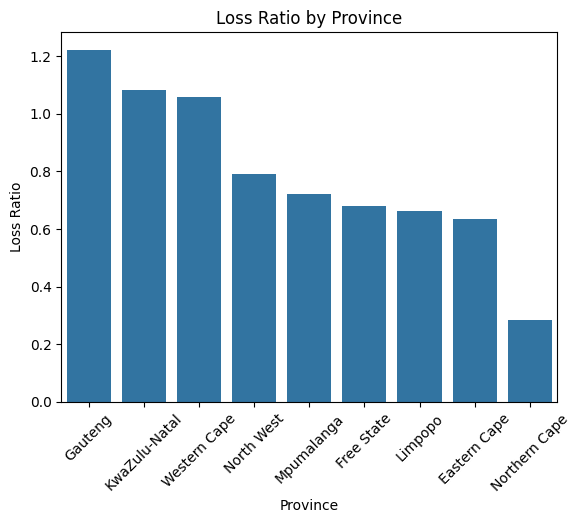

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_by_province = df.groupby('Province')[['TotalClaims', 'TotalPremium']].sum()
loss_by_province['LossRatio'] = loss_by_province['TotalClaims'] / loss_by_province['TotalPremium']
loss_by_province = loss_by_province.sort_values('LossRatio', ascending=False)

sns.barplot(x=loss_by_province.index, y=loss_by_province['LossRatio'])
plt.xticks(rotation=45)
plt.title('Loss Ratio by Province')
plt.ylabel('Loss Ratio')
plt.show()


This bar chart shows the top 10 car makes with the highest average claim amounts, helping identify vehicle brands associated with higher insurance payouts.

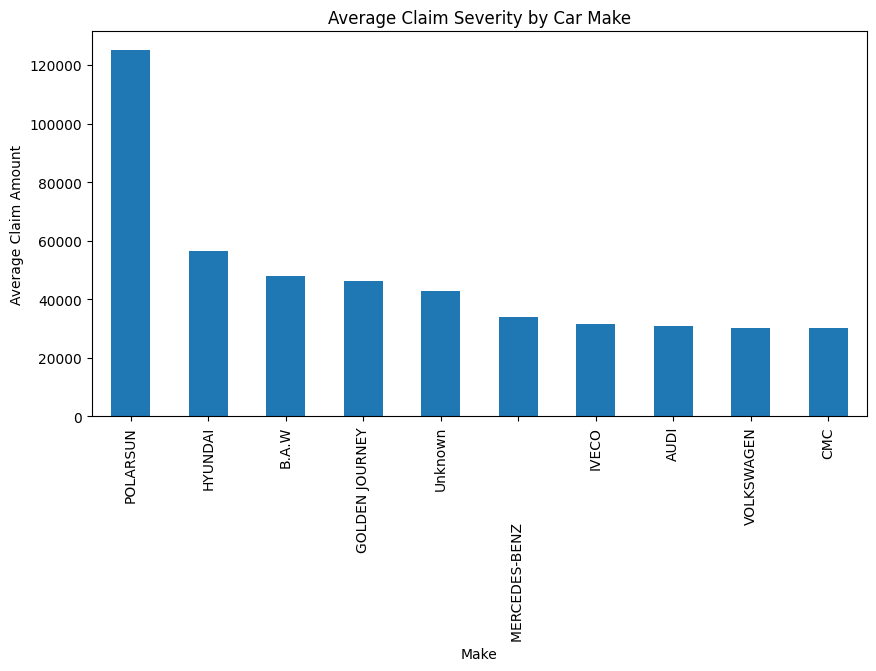

In [23]:
df_claims = df[df['TotalClaims'] > 0]
top_makes = df_claims.groupby('make')['TotalClaims'].mean().sort_values(ascending=False).head(10)

top_makes.plot(kind='bar', figsize=(10, 5), title='Average Claim Severity by Car Make')
plt.ylabel('Average Claim Amount')
plt.xlabel('Make')
plt.show()


This horizontal bar chart compares the loss ratio (claims divided by premiums) across gender, revealing whether male or female policyholders tend to be more costly to insure.

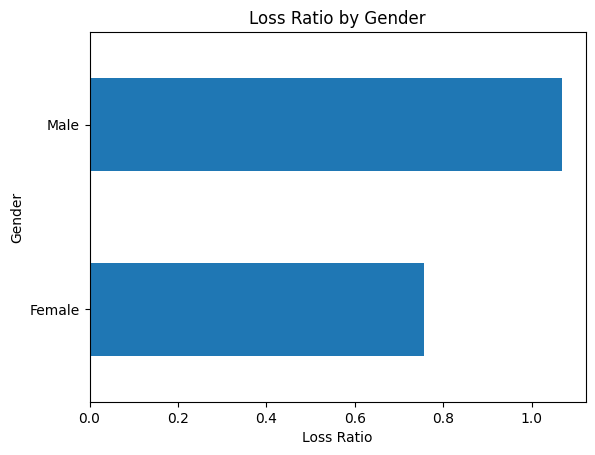

In [29]:
gender_loss = df.groupby('Gender')[['TotalClaims', 'TotalPremium']].sum()
gender_loss['LossRatio'] = gender_loss['TotalClaims'] / gender_loss['TotalPremium']

gender_loss['LossRatio'].sort_values().plot(kind='barh', title='Loss Ratio by Gender')
plt.xlabel('Loss Ratio')
plt.show()


This line chart displays the total premiums and total claims paid out each month, allowing us to observe financial trends and seasonal differences over time.

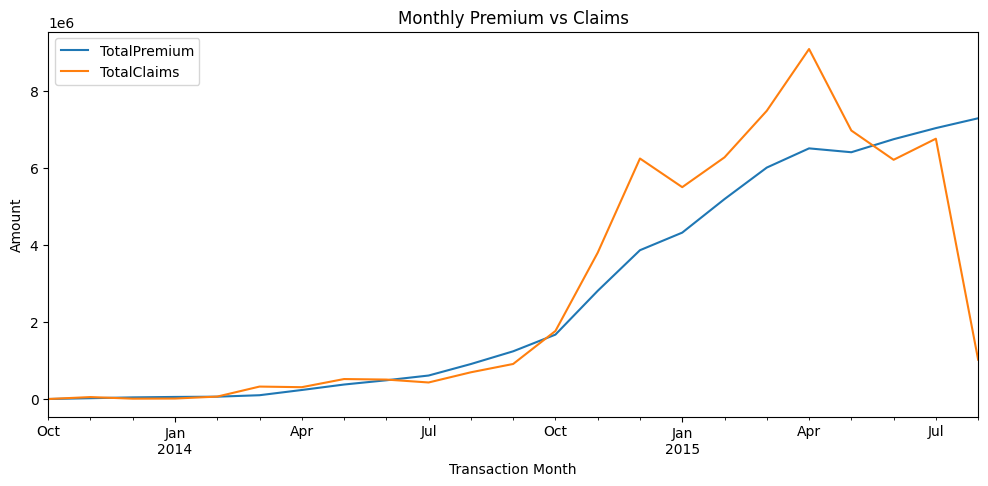

In [19]:
monthly = df.groupby('TransactionMonth')[['TotalPremium', 'TotalClaims']].sum()

monthly.plot(figsize=(12, 5), title='Monthly Premium vs Claims')
plt.ylabel('Amount')
plt.xlabel('Transaction Month')
plt.show()


This heatmap shows the strength of relationships between numerical variables in the dataset, helping identify which features may influence others or be useful for modeling.

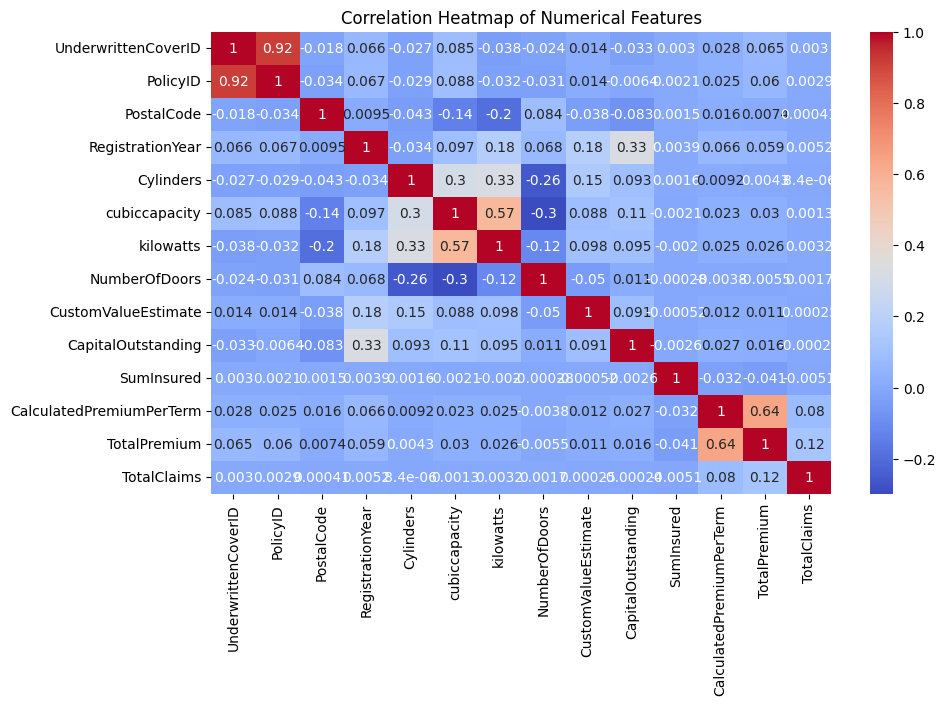

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


This bar plot compares the average claim amount across the top 10 vehicle body types, highlighting which types of vehicles are riskier to insure.

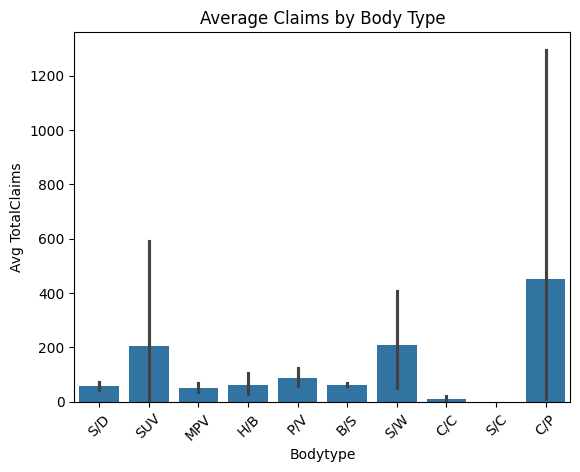

In [21]:
top_bodytypes = df['bodytype'].value_counts().head(10).index
df_v = df[df['bodytype'].isin(top_bodytypes)]

sns.barplot(data=df_v, x='bodytype', y='TotalClaims', estimator='mean')
plt.xticks(rotation=45)
plt.title('Average Claims by Body Type')
plt.ylabel('Avg TotalClaims')
plt.xlabel('Bodytype')
plt.show()


This line chart shows how the number of claims changes over time, helping detect patterns, trends, or unusual spikes in claims month by month.

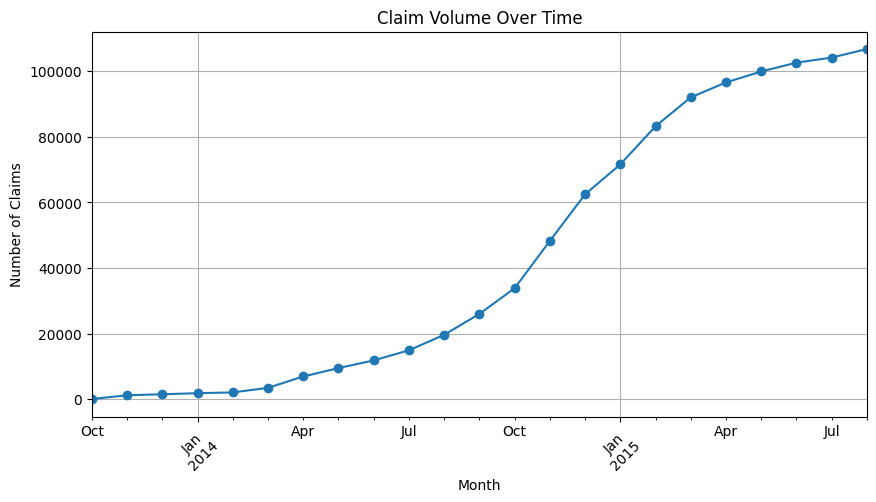

In [24]:
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
monthly_claims = df.groupby(df['TransactionMonth'].dt.to_period('M'))['TotalClaims'].count()

monthly_claims.plot(kind='line', marker='o', figsize=(10, 5), title='Claim Volume Over Time')
plt.ylabel('Number of Claims')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid()
plt.show()
